In [1]:
%pylab inline
from sympy.integrals.quadrature import gauss_lobatto
from sympy.physics.wigner import wigner_3j
from sympy import KroneckerDelta
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import gmres
from scipy.interpolate import interp1d
from mpmath import coulombf
from scipy.special import gamma
from scipy.sparse.linalg import eigs  


Populating the interactive namespace from numpy and matplotlib


In [2]:
def wigfact(l1,l2):
    #calculate wigner3j coeff. with correct prefactor 
    return float(sqrt((2.*l1+1.)*(2.*l2+1.))*wigner_3j(l1, 1, l2, 0,0,0)**2)

def egvalred(a,Vcut):
    #remove high eigenvalues (>Vcut) from matrix 
    e,v=linalg.eig(a)
    ec=array(e)
    ec[abs(ec) > Vcut] = Vcut
    b=v.dot(diag(ec).dot(inv(v)))
    return b

def interplxyxnew(x,y,xnew):
    #interpolate x,y data
    f=interp1d(x, y, kind='linear')
    ynew = f(xnew)
    return(ynew)

In [3]:
class GLQuadrature:
    #costruct gauss_lobatto quadrature grid and derivative matrix
    def __init__(self,n=15):
        x, w = gauss_lobatto(n,15)
        self.x=array(x).astype(float)
        self.w=array(w).astype(float)
        self.n = n
        self.gldmat=self.Derivative()
        
    def Derivative(self):
        #calcualte (one elment [-1,1]) GaussLobatto derivative matrix
        dmat=array([array(zeros(self.n)) for i in range(self.n)])
        for i in range(self.n):
            for j in range(self.n):
                if i!=j:
                    pr=1./(self.x[j]-self.x[i])
                    dmat[i,i]-=pr
                    for k in range(self.n):
                        if (k!=i)and(k!=j):
                            pr*=(self.x[i]-self.x[k])/(self.x[j]-self.x[k])
                    dmat[i,j]+=pr
    
        return dmat
    
        
    def Info(self):
        print ("quadrature order=", self.n)
        
    def Rescale(self,a,b):
        x=(self.x+1.)*(b-a)/(2.)+a
        w=self.w*(b-a)/2.
        return (x,w)
  

In [4]:
class FEMDVR(GLQuadrature):
    #costruct FEMDVR basis from gauss_lobatto quadrature grid (and derivative matrices)
    def __init__(self,fe=[0.,1.,2.],n=5,Vcut=0.):
        GLQuadrature.__init__(self, n=n)
        self.fe=array(fe)
        self.xa,self.wa=self.ConstructFEMDVRgrid()
        self.xz,self.wz=self.xa[1:-1],self.wa[1:-1]
        self.d1matrix,self.d2matrix=self.Getdmat(Vcut=Vcut)
        
    def Info(self):
        GLQuadrature.Info(self)
        print ("        fem grid=", self.fe)
        
        
    def ConstructFEMDVRgrid(self):
        #construct FEM-DVR grid and wights: fe=FEM grid; n=DVR order 
        xa=array([])
        wa=array([])
        wafin=0.
        for i in range(1,len(self.fe)):
            x,w=GLQuadrature.Rescale(self,a=self.fe[i-1],b=self.fe[i])
            w[0]+=wafin
            if(i!=len(self.fe)-1):
                xa=append(xa,x[:-1])
                wa=append(wa,w[:-1])
            else:
                xa=append(xa,x)
                wa=append(wa,w)
            wafin=w[-1]

        return (xa,wa)
    
    
    def Getdmat(self,Vcut=0.):
        nbas=len(self.xz)
        dmat=array([array(zeros(nbas)) for i in range(nbas)]).astype(complex)
        dmat2=array([array(zeros(nbas)) for i in range(nbas)]).astype(complex)
        ntot=len(self.xa)
            
        xi=array(range(ntot))
        b=[]
        for i in range(len(self.fe)-1):
            b.append(xi[-self.n:])
            xi=xi[0:-self.n+1]

        b=array(list(reversed(b)))
        dmatx=array(self.gldmat).astype(complex)
    
        for l in range(len(b)):
            if l==0:
                bb=b[l,1:]
            elif l==len(b)-1:
                bb=b[l,:-1]
            else:
                bb=b[l]
            #print bb#
            for ii in bb:
                i=where( b[l]==ii )[0]
                for jj in bb:
                    j=where( b[l]==jj )[0]
                    de=dmatx[i,j]/(self.fe[l+1]-self.fe[l])*2.*sqrt(self.wa[ii]/self.wa[jj])
                    dmat[ii-1,jj-1]+=de[0]
                    #
                    de=0.
                    for m in range(self.n):
                        de+=dmatx[m,i]*dmatx[m,j]*2./(self.fe[l+1]-self.fe[l])*(self.w[m]/sqrt(self.wa[ii]*self.wa[jj]))
                    dmat2[ii-1,jj-1]-=de[0]
                    #

        for ii in range(self.n-2,len(dmat),self.n-1):
            dmat[ii,:]*=0.5

        if (Vcut != 0.):
            print ("Vcut=",Vcut)
            dmat2=egvalred(dmat2,Vcut)
                
        return (dmat,dmat2) 

 
        
    def FEMDVReval(self,x,k):
        #evaluate FEM-DVR basis functions at any point
        if(x<min(self.fe) or x>max(self.fe)):
            return 0.
        if(k<0 or x>len(self.xa)-1):
            return 0.
            
        ntot=len(self.xa)
        xi=array(range(ntot))
        #print (xi) #
        b=[]
        for i in range(len(self.fe)-1):
            b.append(xi[-self.n:])
            xi=xi[0:-self.n+1]

        b=array(list(reversed(b)))
        #print (b) #

        res=0.
        for bb in enumerate(b):
            if k in  list(bb)[1]:
                xmin=self.xa[list(bb)[1][0]]
                xmax=self.xa[list(bb)[1][-1]]
                if(x>=xmin and x<= xmax):
                    t=1.
                    for i in list(bb)[1]:
                        if (i!=k):
                            t=t*(x-self.xa[i])/(self.xa[k]-self.xa[i])
                    res=res+t
        return res
    
    def FEMDVRevalvec(self,x,v):
        #evaluate FEM-DVR basis for the whole vector
        res=0.
        for k in range(len(self.xz)):
            res+=self.FEMDVReval(x,k+1)*v[k]/sqrt(self.wz[k])
        return res
                

In [5]:
class Hatom(FEMDVR):
    #costruct Hamiltonian for Hydrogen-like atom using FEMDVR basis
    def __init__(self,fe=[0.,5.,10.,20.,30.,40.,50.],n=15,zz=1.,nECS=-1,phiECS=pi/4.,Vcut=0.):
        self.nECS=nECS
        self.zz=zz
        self.phiECS=phiECS

        rECS=fe[nECS]
        feECS=array(fe).astype(complex)
        feECS[nECS:]=rECS + exp(1.j*phiECS)*(feECS[nECS:]-rECS)
        fe=feECS
        
        FEMDVR.__init__(self,fe=fe, n=n,Vcut=Vcut)
        self.h0=self.ConstructH0(zz)
        
    def ConstructH0(self,zz,l=0):
        hamiltonian=-0.5*self.d2matrix
        for ii in range(len(hamiltonian)):
            hamiltonian[ii,ii]=hamiltonian[ii,ii]+0.5*l*(l+1.)/self.xz[ii]**2-zz/self.xz[ii]
        return hamiltonian
    
    def Optical(self,omegamin=0.01,omegamax=2.,omegadelta=0.01,zz=1):
        #
        e,v=linalg.eig(self.h0)
        l1=0
        l2=1
        onephDipOpLen=diag(self.xz)*wigfact(0,1)
        onephDipOpVel=(self.d1matrix.transpose()+diag(0.5/self.xz)*(-l1*(l1*1)+l2*(l2+1)))*wigfact(0,1)
        e0= min(real(e))
        ii = (abs(real(e)-e0)).argmin()
        phi0=v[:,ii]
        phiRHSlen=onephDipOpLen.dot(phi0)
        phiRHSvel=onephDipOpVel.dot(phi0)
        etot=arange(omegamin,omegamax,omegadelta)
        h0=self.ConstructH0(zz=zz,l=1)
        ylen=[]
        yvel=[]
        for en in etot:
            a=diag(zeros(len(hatom.xz))+en)-h0
            clen=linalg.solve(a, phiRHSlen)
            cvel=linalg.solve(a, phiRHSvel)
            plen=-imag(sum(clen*phiRHSlen))
            pvel=-imag(sum(cvel*phiRHSvel))
            ylen.append(plen)
            yvel.append(pvel)
        ylen=array(ylen)
        yvel=array(yvel)
        
        return array([etot,ylen,yvel,etot-e0])
    
    
    

In [6]:
#construct finite elemements
fe=arange(0,250,10).astype(float)
fe=append(fe,fe[-1]+50)
#construct hydrogen atom Hamiltonian using default DVR order
hatom=Hatom(fe=fe,nECS=-4,zz=1,phiECS=deg2rad(30))
H0s=csc_matrix(hatom.h0)
#solve eigenproblem and ptint few lowest eigenvalues
e,v=eigs(H0s,k=4,which='SR')
print (real(sort(e)[:10]))

[-0.5        -0.125      -0.05555556 -0.03125   ]


In [7]:
#test operatos: 
#   calulate cross (photo-absoprtion) setions by using optical theorem
#   only transitinos from l=0 to l=1 (one photon)
etot,ylen,yvel,omega=hatom.Optical()
e0= min(real(e))

#csMbAP=loadtxt("secAusomega_2.dat")
#csSiMbAP=loadtxt("secBusomega.dat")
csAuJF=loadtxt("cs_jf.dat")
csAuSci=loadtxt("cs_sci.dat")
sol=137.0360285534
MBpersqa0=28.0028509
fact=MBpersqa0*(1./sol)*4.*float(pi)

#plot(csMbAP[:,0],csMbAP[:,1],"k-")
plot(csAuJF[:,0],csAuJF[:,1]/1.16,"k-",label="Literature 1")
plot(csAuSci[:,0],csAuSci[:,1],"y--",lw=2,label="Literature 2")
plot(etot-e0,ylen*fact*(omega),"bo",label="Optical t. length gauge")
plot(etot-e0,yvel*fact/(omega),"r.",label="Optical t. velocity gauge")
ylabel("CS[Mb]")
xlabel("$\omega$ [a.u.]")
legend()
show()

In [8]:
#construct general operatos for l=0,..,lmax
lmax=3
ll=arange(lmax+1)

In [9]:
#construct field-free Hamiltonian operator for l=0,..,lmax
#as sparse matrix
data=[]
row_ind=[]
col_ind=[]
for l in ll:
    H0s=csc_matrix(hatom.ConstructH0(zz=1.,l=l))
    data.append(H0s.data)
    rinx=H0s.nonzero()[0]+(l)*len(hatom.h0)
    cinx=H0s.nonzero()[1]+(l)*len(hatom.h0)
    row_ind.append(rinx)
    col_ind.append(cinx)
    
data=array(data).flatten()
row_ind=array(row_ind).flatten()
col_ind=array(col_ind).flatten()

n=len(ll)*len(hatom.h0)
fullh0=csc_matrix((data, (row_ind, col_ind)), shape=(n,n))
fullh0.eliminate_zeros()

In [10]:
#construct dipole operator in length gauge for l=0,..,lmax
#as sparse matrix
data=[]
row_ind=[]
col_ind=[]
for lla in ll:
    for llb in ll:
        data.append(hatom.xz*wigfact(lla,llb))
        rinx=range(len(hatom.h0))+(lla)*len(hatom.h0)
        cinx=range(len(hatom.h0))+(llb)*len(hatom.h0)
        row_ind.append(rinx)
        col_ind.append(cinx)

data=array(data).flatten()
row_ind=array(row_ind).flatten()
col_ind=array(col_ind).flatten()
n=len(ll)*len(hatom.h0)
dipopfulllen=csc_matrix((data, (row_ind, col_ind)), shape=(n,n))
dipopfulllen.eliminate_zeros()

In [11]:
#construct dipole operator in velocity gauge for l=0,..,lmax
#as sparse matrix
data=[]
row_ind=[]
col_ind=[]
for lla in ll:
    for llb in ll:
        hlpMat=csc_matrix((hatom.d1matrix.transpose()+diag(0.5/hatom.xz)*(-lla*(lla+1)+llb*(llb+1))))
        hlpMat.eliminate_zeros()
        data.append(hlpMat.data*wigfact(lla,llb))
        rinx=hlpMat.nonzero()[0]+(lla)*len(hatom.h0)
        cinx=hlpMat.nonzero()[1]+(llb)*len(hatom.h0)
        row_ind.append(rinx)
        col_ind.append(cinx)

data=list(flatten(data))
row_ind=list(flatten(row_ind))
col_ind=list(flatten(col_ind))
n=len(ll)*len(hatom.h0)
dipopfullvel=csc_matrix((data, (row_ind, col_ind)), shape=(n,n))
dipopfullvel.eliminate_zeros()

In [12]:
#construct derivative operator (d/dr) in velocity gauge for l=0,..,lmax
#as sparse matrix
data=[]
row_ind=[]
col_ind=[]
for l in ll:
    d1s=csc_matrix(hatom.d1matrix.transpose())
    if(len(d1s.data)>0):
        data.append(d1s.data)
        rinx=d1s.nonzero()[0]+(l)*len(hatom.h0)
        cinx=d1s.nonzero()[1]+(l)*len(hatom.h0)
        row_ind.append(rinx)
        col_ind.append(cinx)
data=array(data).flatten()
row_ind=array(row_ind).flatten()
col_ind=array(col_ind).flatten()
n=len(ll)*len(hatom.h0)
d1matrixfull=csc_matrix((data, (row_ind, col_ind)), shape=(n,n))
d1matrixfull.eliminate_zeros()

In [13]:
#construct full initial wave function Phi0, for l=0,...,lmax
e0= min(real(e))
ii = (abs(real(e)-e0)).argmin()

phi0full=zeros(fullh0.shape[0]).astype(complex)
phi0full[0:len(v[:,ii])]=v[:,ii]

In [14]:
#test operatos: 
#   calulate cross (photo-absoprtion) setions by using optical theorem
#   full operatos used (l=0,...,lmax)
phiFullRHSlen=dipopfulllen.dot(phi0full)
phiFullRHSvel=dipopfullvel.dot(phi0full)
ylenfull=[]
yvelfull=[]
ylenfullFlux=[]
yvelfullFlux=[]
nint=(hatom.nECS*hatom.n)
omegamin=0.05
omegamax=2.
omegadelta=0.05
etot=arange(omegamin,omegamax,omegadelta)
for en in etot:
    #afull=diag(zeros(len(fullh0))+en)-fullh0
    cafullS=csc_matrix(diag(zeros(fullh0.shape[0])+en))-fullh0
    clenfull=gmres(cafullS, phiFullRHSlen,x0=phiFullRHSlen,tol=1e-08, restart=80)[0]
    cvelfull=gmres(cafullS, phiFullRHSvel,x0=phiFullRHSvel,tol=1e-08, restart=80)[0]
#     clenfull=linalg.solve(afull, phiFullRHSlen)
#     cvelfull=linalg.solve(afull, phiFullRHSvel)
    
    plen=-imag(sum(squeeze(clenfull)*phiFullRHSlen))
    pvel=-imag(sum(squeeze(cvelfull)*phiFullRHSvel))
    ylenfull.append(plen)
    yvelfull.append(pvel)
    
    jcurrentlen=-0.5j*(conjugate(clenfull)*d1matrixfull.dot(clenfull)-clenfull*d1matrixfull.dot(conjugate(clenfull)))
    jcurrentvel=-0.5j*(conjugate(cvelfull)*d1matrixfull.dot(cvelfull)-cvelfull*d1matrixfull.dot(conjugate(cvelfull)))
    l = ll[1]
    i=(l+1)*len(hatom.h0)+nint
    j=len(hatom.h0)+nint
    xl=jcurrentlen[i] /hatom.wz[j]
    xv=jcurrentvel[i] /hatom.wz[j]
    ylenfullFlux.append(abs(xl))
    yvelfullFlux.append(abs(xv))

ylenfull=array(ylenfull)
yvelfull=array(yvelfull)
ylenfullFlux=array(ylenfullFlux)
yvelfullFlux=array(yvelfullFlux)

plot(etot-e0,ylenfullFlux*fact*(etot-e0)/2.,"y.",label="TI flux length")
plot(etot-e0,yvelfullFlux*fact/(etot-e0)/2,"g*",label="TI flux velocity")
plot(omega,ylen*fact*(omega),"r-",label="Optical t.")
## plot(omega,ylenfull*fact*omega,"k--")
## plot(omega,yvelfull*fact/omega,"b:")
ylabel("CS[Mb]")
xlabel("$\omega$ [a.u]")
legend()
show()

In [15]:
#field
#def fieldE(t,omega0=0.6,intensity=1.e12,t0=0,duration=10):
#    if (t<t0):
#        return 0.
#    if (t>t0+duration):
#        return 0.
#    intensity0=3.51e16
#    ampE0=sqrt(intensity/intensity0)
#    f=((sin(pi*t/duration))**2)*(sin(omega0*(t-duration/2)))
#    f=ampE0*f
#    return f

In [16]:
#load electric field and vector potential and Fourier transforms of the pulses
#data calualted with laserfields (https://github.com/jfeist/laserfields)

import matplotlib.pyplot as plt
f, ax = plt.subplots(1,2, figsize=(10,4))

fieldE=loadtxt("fieldtest/Field.txt")
duration=fieldE[-1,0]
#t=arange(0.,duration,0.05)
#f=[fieldE(x,omega0=1.,intensity=1.e12,t0=0,duration=duration) for x in t]
#ax[0].plot(t,f,"g.")
ax[0].plot(fieldE[:,0],fieldE[:,1],"r-",label="El. field")
ax[0].plot(fieldE[:,0],fieldE[:,2],"b-",label="Vec. potential")
ax[0].legend()
ax[0].axvline(x=duration/2.)
ax[0].set_xlabel("t[a.u.]")
ax[0].set_ylabel("E[a.u.]")

fourierE=loadtxt("fieldtest/Fourier.txt")
ax[1].plot(fourierE[:,0],sqrt(fourierE[:,3]**2+fourierE[:,4]**2),"b-",label="FT. vec. pot")
ax[1].plot(fourierE[:,0],sqrt(fourierE[:,1]**2+fourierE[:,2]**2),"r-",label="FT. el. field")
ax[1].legend()
ax[1].axvline(x=0.8)
ax[1].set_xlabel(r"$\omega$[a.u.]")
ax[1].set_ylabel(r"|Fourier(f)|[a.u.]")
show()

In [17]:
import scipy.sparse.linalg as spla

def CNtdse(phi0,H0,V,dt,fieldE):
    # propagatge wave function using Crank–Nicolson propagator for TDSE
    H2=H0*0.5j*dt
    V2=V*0.5j*dt
    ID=identity(H0.shape[0])
    # (1+idt/2*H)x=(1-idt/2*H)u    
    H2s=csc_matrix(H2)
    IDs=csc_matrix(ID)
    V2s=csc_matrix(V2)
    
    t0=0.
    t1=duration
    phi0final=phi0
    for t in arange(t0,t1,dt):
        f=interplxyxnew(fieldE[:,0],fieldE[:,1],t)
        Hs=f*V2s
        Hs+=H2s
        rhs=phi0final-Hs.dot(phi0final)
        LHS=IDs+Hs
        #phi0final = spsolve(LHS, rhs)
        phi0final, exitCode = spla.gmres(LHS, rhs,x0=phi0final,tol=1e-08) #bicgstab, gmres more accruate but slower
        if(exitCode!=0):
            print("not converged: t=",t)
            return phi0final
            
    return phi0final

def CNtdseFree(phi0,H0,dt):
    H2=H0*0.5j*dt
    ID=identity(len(H0))
    # (1+idt/2*H)x=(1-idt/2*H)u    
    H2R=csc_matrix(ID-H2)
    H2L=csc_matrix(ID+H2)
    t0=0.
    t1=duration
    phi0final=phi0
    for t in arange(t0,t1,dt):
        rhs=H2R.dot(phi0final)
        phi0final = spsolve(H2L, rhs)
    return phi0final


def Padetdse(phi0,H0,V,dt):
    H2=H0*1.j*dt
    V2=V*1.j*dt
    H2s=csc_matrix(H2)
    V2s=csc_matrix(V2)
    
    t0=0.
    t1=duration
    phi0final=phi0
    for t in arange(t0,t1,dt):
        f=interplxyxnew(fieldE[:,0],fieldE[:,1],t)
        Hs=f*V2s
        Hs+=H2s
        phi0final=spla.expm(Hs).dot(phi0final)
            
    return phi0final

In [18]:
#solve TDSE
dt=0.025
gauge="len"

if (gauge=="vel"):
    t1=time.time()
    phi0finalvel=CNtdse(phi0full,fullh0,dipopfullvel,dt,fieldE)
    phi0final=phi0finalvel
    t2=time.time()
    print("t1-t2=",t2-t1)

if (gauge=="len"):
    t1=time.time()
    phi0finallen=CNtdse(phi0full,fullh0,dipopfulllen,dt,fieldE)
    phi0final=phi0finallen
    print (sum(abs(phi0finallen)**2))
    t2=time.time()
    print("t1-t2=",t2-t1)

1.000000000737245
t1-t2= 0.9839150905609131


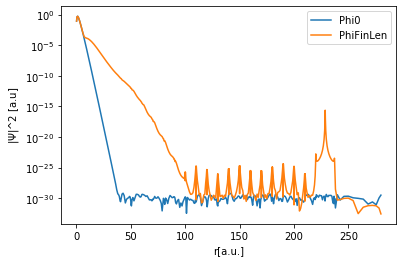

In [19]:
#plot norm of the wave functions 

fhifintot=zeros(len(hatom.xz))
for l in ll[0::]:
    fhifintot+=abs(phi0full[l*len(hatom.h0):(l+1)*len(hatom.h0)])**2/abs(hatom.wz)
plot(real(hatom.xz),fhifintot,label="Phi0")

if (gauge=="len"):
    fhifintot=zeros(len(hatom.xz))
    for l in ll[0::]:
        fhifintot+=abs(phi0finallen[l*len(hatom.h0):(l+1)*len(hatom.h0)])**2/abs(hatom.wz)
    plot(real(hatom.xz),fhifintot,label="PhiFinLen")

if (gauge=="vel"):
    fhifintot=zeros(len(hatom.xz))
    for l in ll:
       fhifintot+=abs(phi0finalvel[l*len(hatom.h0):(l+1)*len(hatom.h0)])**2
    plot(real(hatom.xz),fhifintot/abs(hatom.wz),label="PhiFinVel")

ylabel("|$\Psi$|^2 [a.u]")
xlabel("r[a.u.]")
legend()
#xlim(0,9)
yscale("log")

In [20]:
energy=arange(0.6,1.1,0.05)+e0

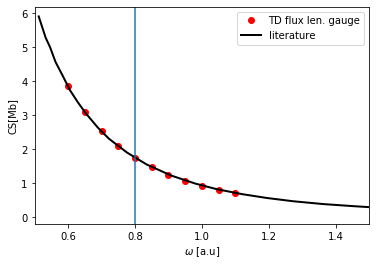

In [21]:
#calcualte photo-absoption cross sectin by calculating qm flux 
nint=(hatom.nECS*hatom.n)
y1=[]
for en in energy:
    afullS=csc_matrix(diag(zeros(fullh0.shape[0])+en))-fullh0
    phiSW=gmres(afullS, phi0final,x0=phi0final,tol=1e-08, restart=80)[0]

    
    jcurrent=conjugate(phiSW)*d1matrixfull.dot(phiSW)-phiSW*conjugate(d1matrixfull.dot(phiSW))
    jcurrent*=-0.5j
    x=0.
    for l in ll[1::2]:
        i=(l+1)*len(hatom.h0)+nint
        j=len(hatom.h0)+nint
        x=x+jcurrent[i] /hatom.wz[j]
    y1.append(x)

y1=array(y1)

xlim(0.5,1.5)
sol=137.0360285534
MBpersqa0=28.0028509
fact=MBpersqa0*(1./sol)
frw=array(interplxyxnew(fourierE[:,0],fourierE[:,1]**2+fourierE[:,2]**2,energy-e0))
if (gauge=="len"):
    gaugefact=(energy-e0)
if (gauge=="vel"):
    gaugefact=1/(energy-e0)
plot((energy-e0),real(y1)*fact/frw*gaugefact,"ro",label="TD flux "+gauge+". gauge")
plot(csAuSci[:,0],csAuSci[:,1],"k-",lw=2,label="literature")
axvline(x=.8)
ylabel("CS[Mb]")
xlabel("$\omega$ [a.u]")
legend()
show()

In [22]:
#calcualte photo-inisation cross sectin by using testing functions and surface integral

eo=-0.5
energy=arange(0.6,1.1,0.05)+e0
nint=len(hatom.xz[imag(hatom.xz)==0])-15
y2=[]
for en in energy:
    vectork=sqrt(2.*en)
    afullS=csc_matrix(diag(zeros(fullh0.shape[0])+en))-fullh0
    phiSW=gmres(afullS, phi0final,x0=phi0final,tol=1e-08, restart=80)[0]
    
    phiC=array([]).astype(complex)
    phiCD=array([]).astype(complex)
    eta=-hatom.zz/sqrt(2.*en)
    for l in ll:
        ii=(l)*len(hatom.h0)
        zarg=l+1.0+1.j*eta
        gval=gamma(zarg)
        phase=(1.j)**(-l)*gval/abs(gval)
        
        rr=abs(hatom.xz)
        y=array([float(coulombf(l,eta,rr[k]*sqrt(2*en)))*sqrt(real(hatom.wz[k])) for k in range(len(rr))])
        dy=real(hatom.d1matrix.dot(y))
        y=y.astype(complex)*phase
        dy=dy.astype(complex)*phase
        phiC=append(phiC,y)
        phiCD=append(phiCD,dy)

    phiC.flatten()
    phiCD.flatten
    subint=phiC*(d1matrixfull).dot(phiSW)-phiSW*phiCD
    x=0.+0j
    for l in ll[1:2]:
        i=l*len(hatom.h0)+nint
        j=nint
        x=x+subint[i]/hatom.wz[j]
    fact=1/2.*(sqrt(2./(pi*vectork)))
    x*=fact
    y2.append(x)

y2=array(y2)

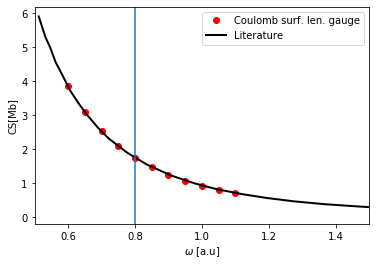

In [23]:
xlim(0.5,1.5)
sol=137.0360285534
MBpersqa0=28.0028509
fact=MBpersqa0*(1./sol)
frw=array(interplxyxnew(fourierE[:,0],fourierE[:,1]**2+fourierE[:,2]**2,energy-e0))
if (gauge=="len"):
    gaugefact=(energy-e0)
if (gauge=="vel"):
    gaugefact=1/(energy-e0)
plot((energy-e0),abs(y2)**2*fact/frw*gaugefact*2*pi,"ro",label="Coulomb surf. "+gauge+". gauge")
plot(csAuSci[:,0],csAuSci[:,1],"k-",lw=2,label="Literature")
axvline(x=.8)
ylabel("CS[Mb]")
xlabel("$\omega$ [a.u]")
legend()